In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1701456433243_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1701456433243_0002,pyspark,idle,Link,Link,None,✔


### Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

###  Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://ze-p8-data'
PATH_Data = PATH+'/Test50'
PATH_Result = PATH+'/Results50'
PATH_Result_csv = PATH+'/Results50_csv'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://ze-p8-data
PATH_Data:   s3://ze-p8-data/Test50
PATH_Result: s3://ze-p8-data/Results50

###  Traitement des données

####  Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://ze-p8-data/T...|2023-11-07 19:31:09|  7218|[FF D8 FF E0 00 1...|
|s3://ze-p8-data/T...|2023-11-07 19:31:12|  7209|[FF D8 FF E0 00 1...|
|s3://ze-p8-data/T...|2023-11-07 19:31:11|  7207|[FF D8 FF E0 00 1...|
|s3://ze-p8-data/T...|2023-11-07 19:31:11|  7174|[FF D8 FF E0 00 1...|
|s3://ze-p8-data/T...|2023-11-07 19:31:10|  7162|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-----------------------------------------------+----------+
|path                                           |label     |
+-----------------------------------------------+----------+
|s3://ze-p8-data/Test50/Watermelon/r_71_100.jpg |Watermelon|
|s3://ze-p8-data/Test50/Watermelon/r_75_100.jpg |Watermelon|
|s3://ze-p8-data/Test50/Watermelon/r_76_100.jpg |Watermelon|
|s3://ze-p8-data/Test50/Watermelon/r_82_100.jpg |Watermelon|
|s3://ze-p8-data/Test50/Watermelon/r_105_100.jpg|Watermelon|
+-----------------------------------------------+----------+
only showing top 5 rows

None

#### Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1701456433243_0002/container_1701456433243_0002_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:403: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

####  Exécutions des actions d'extractions de features

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.repartition(5).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://ze-p8-data/Results50

# Réduction de dimension avec Spark PCA

## Standardisation avec StandardScaler 

In [17]:
features_df 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[path: string, label: string, features: array<float>]

In [18]:
# Define a UDF to convert the array to VectorUDT
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to convert the "features" column to VectorUDT
features_df_vec = features_df.withColumn("features_vector", array_to_vector_udf(features_df["features"]))
features_df_vec.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+
|                path|     label|            features|     features_vector|
+--------------------+----------+--------------------+--------------------+
|s3://ze-p8-data/T...|Watermelon|[0.84153956, 0.12...|[0.84153956174850...|
|s3://ze-p8-data/T...|  Tomato 4|[0.0, 1.2091407, ...|[0.0,1.2091406583...|
|s3://ze-p8-data/T...|Watermelon|[0.0, 0.088264115...|[0.0,0.0882641151...|
|s3://ze-p8-data/T...|    Orange|[0.08757388, 0.0,...|[0.08757387846708...|
|s3://ze-p8-data/T...|Watermelon|[0.71647257, 0.29...|[0.71647256612777...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows

In [19]:
scaler = StandardScaler(
    inputCol = 'features_vector', 
    outputCol = 'scaled_features',
    withMean = True,
    withStd = True)
scaler_fitted = scaler.fit(features_df_vec)
# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler_fitted.transform(features_df_vec)
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|     label|            features|     features_vector|     scaled_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3://ze-p8-data/T...|Watermelon|[0.84153956, 0.12...|[0.84153956174850...|[1.47916815247264...|
|s3://ze-p8-data/T...|  Tomato 4|[0.0, 1.2091407, ...|[0.0,1.2091406583...|[-0.8488865387274...|
|s3://ze-p8-data/T...|Watermelon|[0.0, 0.088264115...|[0.0,0.0882641151...|[-0.8488865387274...|
|s3://ze-p8-data/T...|    Orange|[0.08757388, 0.0,...|[0.08757387846708...|[-0.6066201167326...|
|s3://ze-p8-data/T...|Watermelon|[0.71647257, 0.29...|[0.71647256612777...|[1.13317989582530...|
|s3://ze-p8-data/T...|    Banana|[0.8996768, 0.016...|[0.89967679977416...|[1.64000036508763...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 6 rows

In [20]:
# Après l'étape de prétraitement, nous ajustons le modèle PCA (Analyse en Composantes Principales).

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Specify the number of principal components you want
num_components = 100
# Create a PCA model and fit it to the scaled data
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
# Transform the DataFrame to obtain the PCA features
pca_result_df = pca_model.transform(df_scaled)
# Extract the explained variance
explained_variance = pca_model.explainedVariance.toArray()
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Create a plot to identify the elbow point
plt.figure() 
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")

# You can also display the plot or save it to a file
plt.show()

# Set the cumulative variance threshold
threshold = 0.80

# Find the number of components when cumulative variance >= threshold
num_selected_components = None
for i, cum_var in enumerate(cumulative_variance):
    if cum_var >= threshold:
        num_selected_components = i + 1
        break

if num_selected_components is not None:
    print(f"Number of components for cumulative variance >= {threshold}: {num_selected_components}")
else:
    print("Cumulative variance threshold not reached with the given number of components.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of components for cumulative variance >= 0.8: 13

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

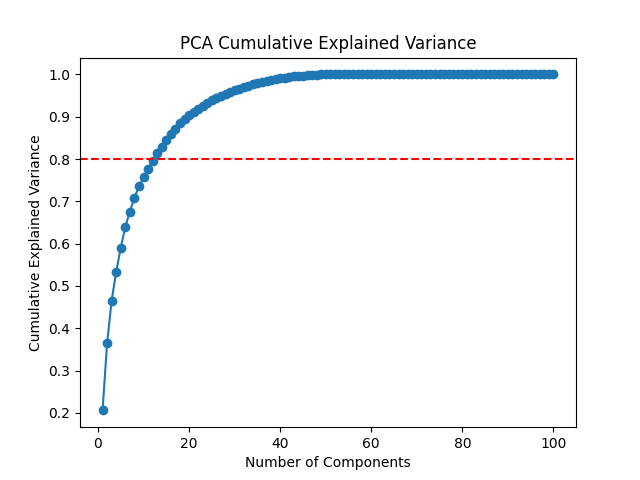

In [22]:
%matplot plt

In [23]:
# On peut expliquer 80 % de la variance avec 13 composants.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## PCA avec 13 composantes

In [24]:
# Specify the number of principal components you want
num_components = 13
# Create a PCA model and fit it to the scaled data
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
# Transform the DataFrame to obtain the PCA features
pca_result_df = pca_model.transform(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
pca_result_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|                path|     label|            features|     features_vector|     scaled_features|        pca_features|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|s3://ze-p8-data/T...|Watermelon|[0.84153956, 0.12...|[0.84153956174850...|[1.47916815247264...|[-9.2983841123325...|
|s3://ze-p8-data/T...|  Tomato 4|[0.0, 1.2091407, ...|[0.0,1.2091406583...|[-0.8488865387274...|[15.5664943854825...|
|s3://ze-p8-data/T...|Watermelon|[0.0, 0.088264115...|[0.0,0.0882641151...|[-0.8488865387274...|[-0.1159279071585...|
|s3://ze-p8-data/T...|    Orange|[0.08757388, 0.0,...|[0.08757387846708...|[-0.6066201167326...|[6.67060986466664...|
|s3://ze-p8-data/T...|Watermelon|[0.71647257, 0.29...|[0.71647256612777...|[1.13317989582530...|[-11.162601541173...|
+--------------------+----------+--------------------+--

# Projection des individus sur deux composantes principales de PCA

In [26]:
df_final_pca = pca_result_df.select('path', 'label', 'pca_features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Convert the Spark DataFrame to a Pandas DataFrame for easy plotting
pandas_df = df_final_pca.select("label", "pca_features").toPandas()

# Extract PCA components from the "pca_features" column
pandas_df["pca_1"] = pandas_df["pca_features"].apply(lambda x: x[0])
pandas_df["pca_2"] = pandas_df["pca_features"].apply(lambda x: x[1])

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pandas_df["pca_1"], pandas_df["pca_2"],
                      c=pandas_df["label"].astype('category').cat.codes, cmap='plasma')
plt.title('Projection des individus sur deux composantes principales')
plt.xlabel('Principal Composante 1')
plt.ylabel('Principal Composante 2')

# Adding legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
           for label, color in zip(pandas_df["label"].unique(),
                                   scatter.to_rgba(range(len(pandas_df["label"].unique()))))]
plt.legend(handles=handles, title='Fruit Labels')

plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

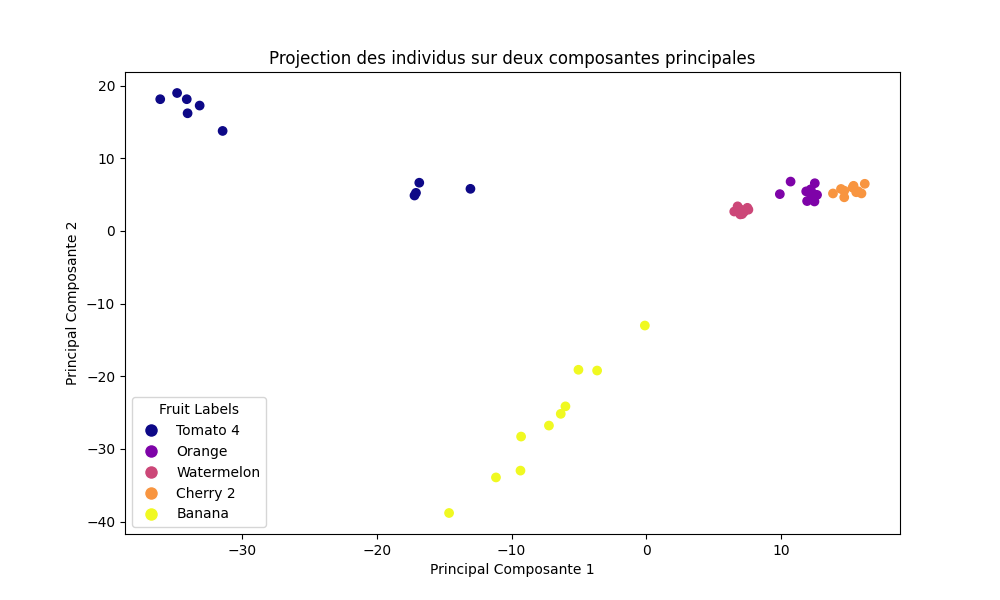

In [28]:
%matplot plt

In [29]:
# On constate que les classes des fruits ont été bien distinguées.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exportation des features pca en csv et en parquet sur un bucket S3

In [30]:
df_final_pca = pca_result_df.select('path', 'label', 'pca_features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
df_final_pca.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
df_pca = spark.read.parquet(PATH_Result)
df_pca = df_pca.toPandas()
df_pca.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                             path  ...                                       pca_features
0  s3://ze-p8-data/Test50/Watermelon/r_53_100.jpg  ...  [-7.231568838931274, -26.787846012327503, -3.2...
1        s3://ze-p8-data/Test50/Orange/68_100.jpg  ...  [7.235177698506473, 2.6287589369938007, 18.886...
2        s3://ze-p8-data/Test50/Orange/75_100.jpg  ...  [7.4909010378620815, 3.191525286346196, 17.598...
3     s3://ze-p8-data/Test50/Tomato 4/122_100.jpg  ...  [14.437170213469516, 5.786769095167864, -11.99...
4      s3://ze-p8-data/Test50/Orange/r_75_100.jpg  ...  [6.515947918400484, 2.6802584861433503, 18.351...

[5 rows x 3 columns]

In [33]:
# sauvegarde en format csv
from pyspark.sql.types import StringType
format_udf = udf(lambda x: str(x), StringType()) 

df_csv = df_final_pca.repartition(1).withColumn('pca_features', format_udf(col('pca_features')))

df_csv.write.mode("overwrite").option("delimiter", "\t").option("header", "true").csv(PATH_Result_csv)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
spark.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…